In [1]:
import matplotlib.pyplot as plt
from spacepy import pycdf
import numpy as np
import matplotlib.dates as mdates
import math
import datetime as dt
import statistics
from datetime import datetime, timedelta
from matplotlib.ticker import ScalarFormatter
from sunpy.net import Fido
import sunpy.net.attrs as attrs
import sunpy_soar
from matplotlib.axis import Axis
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.pyplot import cm
import matplotlib.pylab as pl
import matplotlib
from itertools import compress

C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Start-End Time of Event
start_event = '14:10:00'
end_event = '14:50:00'
date = '2022-04-10'
date_init, date_end = date, date
bools = [False, True]
save_results = bools[1]

In [3]:
'''# Set input arguments to fetch for RPW data files
instrument = attrs.Instrument('RPW')
time = attrs.Time(date_init, date_end)
level = attrs.Level(2)
product = attrs.soar.Product('RPW-HFR-SURV')'''

"# Set input arguments to fetch for RPW data files\ninstrument = attrs.Instrument('RPW')\ntime = attrs.Time(date_init, date_end)\nlevel = attrs.Level(2)\nproduct = attrs.soar.Product('RPW-HFR-SURV')"

In [4]:
'''# Perform search for RPW data files
result = Fido.search(instrument & time & level & product)
display(result)'''

'# Perform search for RPW data files\nresult = Fido.search(instrument & time & level & product)\ndisplay(result)'

In [5]:
'''# Download files in /Data folder
files = Fido.fetch(result, path='Data', overwrite=True, progress=True)
display(files)'''

"# Download files in /Data folder\nfiles = Fido.fetch(result, path='Data', overwrite=True, progress=True)\ndisplay(files)"

In [6]:
'''cdf_file = pycdf.CDF(files[0])
cdf_file'''

'cdf_file = pycdf.CDF(files[0])\ncdf_file'

In [7]:
cdf_file = pycdf.CDF('RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220410_V06')
cdf_file

<CDF:
AGC1: CDF_DOUBLE [2141500]
AGC2: CDF_DOUBLE [2141500]
AVERAGE_NR: CDF_UINT1 [2141500]
BANDWIDTH: CDF_UINT1 [1] NRV
CHANNEL_LABEL: CDF_CHAR*8 [2] NRV
CHANNEL_STATUS: CDF_UINT1 [2141500, 2]
DELTA_TIME: CDF_REAL8 [2141500]
Epoch: CDF_TIME_TT2000 [2141500]
FREQUENCY: CDF_UINT2 [2141500]
FRONT_END: CDF_UINT1 [2141500]
HFR_BAND: CDF_UINT1 [2141500]
INTEGRATION_TIME: CDF_UINT1 [1] NRV
NUM: CDF_UINT4 [2141500]
QUALITY_BITMASK: CDF_UINT2 [2141500]
QUALITY_FLAG: CDF_UINT1 [2141500]
RPW_STATUS: CDF_UINT1 [2141500, 15]
RPW_STATUS_LABEL: CDF_CHAR*16 [15] NRV
SAMPLE_TIME: CDF_REAL8 [2141500]
SENSOR_CONFIG: CDF_UINT1 [2141500, 2]
SURVEY_MODE: CDF_UINT1 [2141500]
SWEEP_MODE: CDF_UINT1 [2141500]
SWEEP_NUM: CDF_UINT4 [2141500]
SYNCHRO_FLAG: CDF_UINT1 [2141500]
TEMPERATURE: CDF_UINT1 [2141500, 4]
TEMPERATURE_LABEL: CDF_CHAR*8 [4] NRV
TICKS_NR: CDF_UINT4 [2141500]
TIME_INTERPOL_FLAG: CDF_UINT1 [0]
>

In [8]:
cdf_file['SENSOR_CONFIG'].attrs

<zAttrList:
CATDESC: THR sensor configuration [CDF_CHAR]
DEPEND_0: Epoch [CDF_CHAR]
DISPLAY_TYPE: time_series [CDF_CHAR]
FIELDNAM: SENSOR_CONFIG [CDF_CHAR]
FILLVAL: 255 [CDF_UINT1]
FORMAT: I1.1 [CDF_CHAR]
LABLAXIS: THR sensor config. [CDF_CHAR]
SCALEMAX: 11 [CDF_UINT1]
SCALEMIN: 1 [CDF_UINT1]
SCALETYP: linear [CDF_CHAR]
UNITS:   [CDF_CHAR]
VALIDMAX: 11 [CDF_UINT1]
VALIDMIN: 1 [CDF_UINT1]
VAR_NOTES: Indicates the THR sensor configuration (V1=1, V2=2, V3=3, V1-V2=4, V2-V3=5, V3-V1=6, B_MF=7, HF_V1-V2=9, HF_V2-V3=10, HF_V3-V1=11) [CDF_CHAR]
VAR_TYPE: data [CDF_CHAR]
>

In [9]:
def array_dupes(a):
    u, c = np.unique(a, return_counts=True)
    dup = u[c > 1]
    return dup

def halfpeak_avg(a, b):
    peak_condition = np.where(b > np.max(b)/2)
    peak_ratio = a[peak_condition]
    return np.average(peak_ratio)
    
def halfpeak_err(a, b):
    peak_condition = np.where(b > np.max(b)/2)
    peak_ratio = a[peak_condition]
    return np.std(peak_ratio)

def available_time(t):
    return np.mod(t, math.ceil(delta_t_hours))

def to_timestamp(array): # Converts datetime arrays into timestamp arrays
    timestamps = list(map(lambda x: datetime.timestamp(x), array))
    return timestamps

def to_date(array): # Converts timestamp arrays into datetime arrays
    mydates = list(map(lambda x: datetime.fromtimestamp(x), array))
    return mydates

def join_sensors(x, y, n):
    x_non = np.where(x <= n)
    x[x_non] = y[x_non]
    return x

def FWHM(t, f):
        half = np.max(f)/2.
        i = np.where(f >= half)
        return [t[np.min(i)], t[np.max(i)]]

def freq_chooser(a, m):
    choice = list(map(lambda x: len(x) == m, a))
    return choice

myFmt = mdates.DateFormatter('%H:%M')

In [10]:
freq_, epoch_, AGC_, sensor_ = cdf_file['FREQUENCY'][...], cdf_file['Epoch'][...], join_sensors(cdf_file['AGC1'][...], cdf_file['AGC2'][...], 0), join_sensors(cdf_file['SENSOR_CONFIG'][:,0], cdf_file['SENSOR_CONFIG'][:,1], 8)    
condition = np.where((sensor_==9)|(sensor_==10)|(sensor_==11))
freq, epoch, AGC, sensor = freq_[condition], epoch_[condition], AGC_[condition], sensor_[condition]

freq_list = [425.0 , 525.0 , 625.0 ,  675.0 , 775.0 , 875.0 , 975.0 , 1025.0 , 1225.0 , 1375.0 , 1475.0 , 
             1725.0 , 1825.0 , 2075.0 , 2425.0 , 2675.0 , 3325.0 , 3925.0 , 4525.0 , 5225.0 , 5825.0 , 
             6525.0 , 7625.0 , 8225.0 , 10125.0]

freq_choice_ = list(map(lambda x: np.where(freq==x), freq_list)) # Find indexes for frequencies
epoch_choice_ = list(map(lambda x: epoch[x], freq_choice_)) # Find time index for frequencies
AGC_choice_ = list(map(lambda x: AGC[x], freq_choice_)) # Find count number for frequencies
sensor_choice_ = list(map(lambda x: sensor[x], freq_choice_)) # Find sensor for frequencies
print(freq_list)

[425.0, 525.0, 625.0, 675.0, 775.0, 875.0, 975.0, 1025.0, 1225.0, 1375.0, 1475.0, 1725.0, 1825.0, 2075.0, 2425.0, 2675.0, 3325.0, 3925.0, 4525.0, 5225.0, 5825.0, 6525.0, 7625.0, 8225.0, 10125.0]


In [11]:
freq_choice = np.concatenate(freq_choice_, axis=0) # Reduce dimensions and transform into array
epoch_choice = np.stack(epoch_choice_, axis=0) # Transform into array
AGC_choice = np.stack(AGC_choice_, axis=0) # Transform into array
sensor_choice = np.stack(sensor_choice_, axis=0)

In [12]:
epoch_9, epoch_10, epoch_11 = [], [], []
AGC_9, AGC_10, AGC_11 = [], [], []
freq_num = len(freq_list)

for i in range(0, freq_num):
    s9, s10, s11 = np.where(sensor_choice[i]==9), np.where(sensor_choice[i]==10), np.where(sensor_choice[i]==11)
    epoch_9.append(epoch_choice[i][s9[0]]), AGC_9.append(AGC_choice[i][s9[0]])
    epoch_10.append(epoch_choice[i][s10[0]]), AGC_10.append(AGC_choice[i][s10[0]])
    epoch_11.append(epoch_choice[i][s11[0]]), AGC_11.append(AGC_choice[i][s11[0]])
 

# Run from here after changing time-interval

In [13]:
yyyy, mm, dd = date.split('-')
HH_s, MM_s, SS_s = start_event.split(':')
HH_e, MM_e, SS_e = end_event.split(':')
time_start = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_s), int(MM_s), int(SS_s))
time_end = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_e), int(MM_e), int(SS_e))

def time_inter(t_arr):
    start = np.abs(np.array(to_timestamp(t_arr))-datetime.timestamp(time_start)).argmin()
    end = np.abs(np.array(to_timestamp(t_arr))-datetime.timestamp(time_end)).argmin()
    return [start, end]

middle_freq = math.ceil(len(freq_list)/2.)
start = time_inter(epoch_9[middle_freq])[0]
end = time_inter(epoch_9[middle_freq])[1]

In [14]:
def ten_min_cal(t, f):
    f_max = np.argmax(f[start:end])
    t_max = t[start:end]
    m = np.where(t == t_max[f_max])
    di = t[m[0]]-timedelta(minutes = 50)
    df = t[m[0]]-timedelta(minutes = 40)
    i = np.abs(np.array(to_timestamp(t))- datetime.timestamp(di[0])).argmin()
    j = np.abs(np.array(to_timestamp(t))- datetime.timestamp(df[0])).argmin()
    c = np.median(f[i:j])
    return c

def ten_min_cal_plus(t, f):
    f_max = np.argmax(f[start:end])
    t_max = t[start:end]
    m = np.where(t == t_max[f_max])
    di = t[m[0]]+timedelta(minutes = 20)
    df = t[m[0]]+timedelta(minutes = 30)
    i = np.abs(np.array(to_timestamp(t))- datetime.timestamp(di[0])).argmin()
    j = np.abs(np.array(to_timestamp(t))- datetime.timestamp(df[0])).argmin()
    c = np.median(f[i:j])
    return c

C:\Users\franc\AppData\Local\Temp/ipykernel_38516/2535404921.py:20: RuntimeWarning: divide by zero encountered in divide
  ratio_9_10 = AGC_axis_9/AGC_axis_10
C:\Users\franc\AppData\Local\Temp/ipykernel_38516/2535404921.py:21: RuntimeWarning: divide by zero encountered in divide
  ratio_9_11 = AGC_axis_9/AGC_axis_11
C:\Users\franc\AppData\Local\Temp/ipykernel_38516/2535404921.py:22: RuntimeWarning: divide by zero encountered in divide
  ratio_10_11 = AGC_axis_10/AGC_axis_11
C:\Users\franc\AppData\Local\Temp/ipykernel_38516/2535404921.py:20: RuntimeWarning: invalid value encountered in divide
  ratio_9_10 = AGC_axis_9/AGC_axis_10


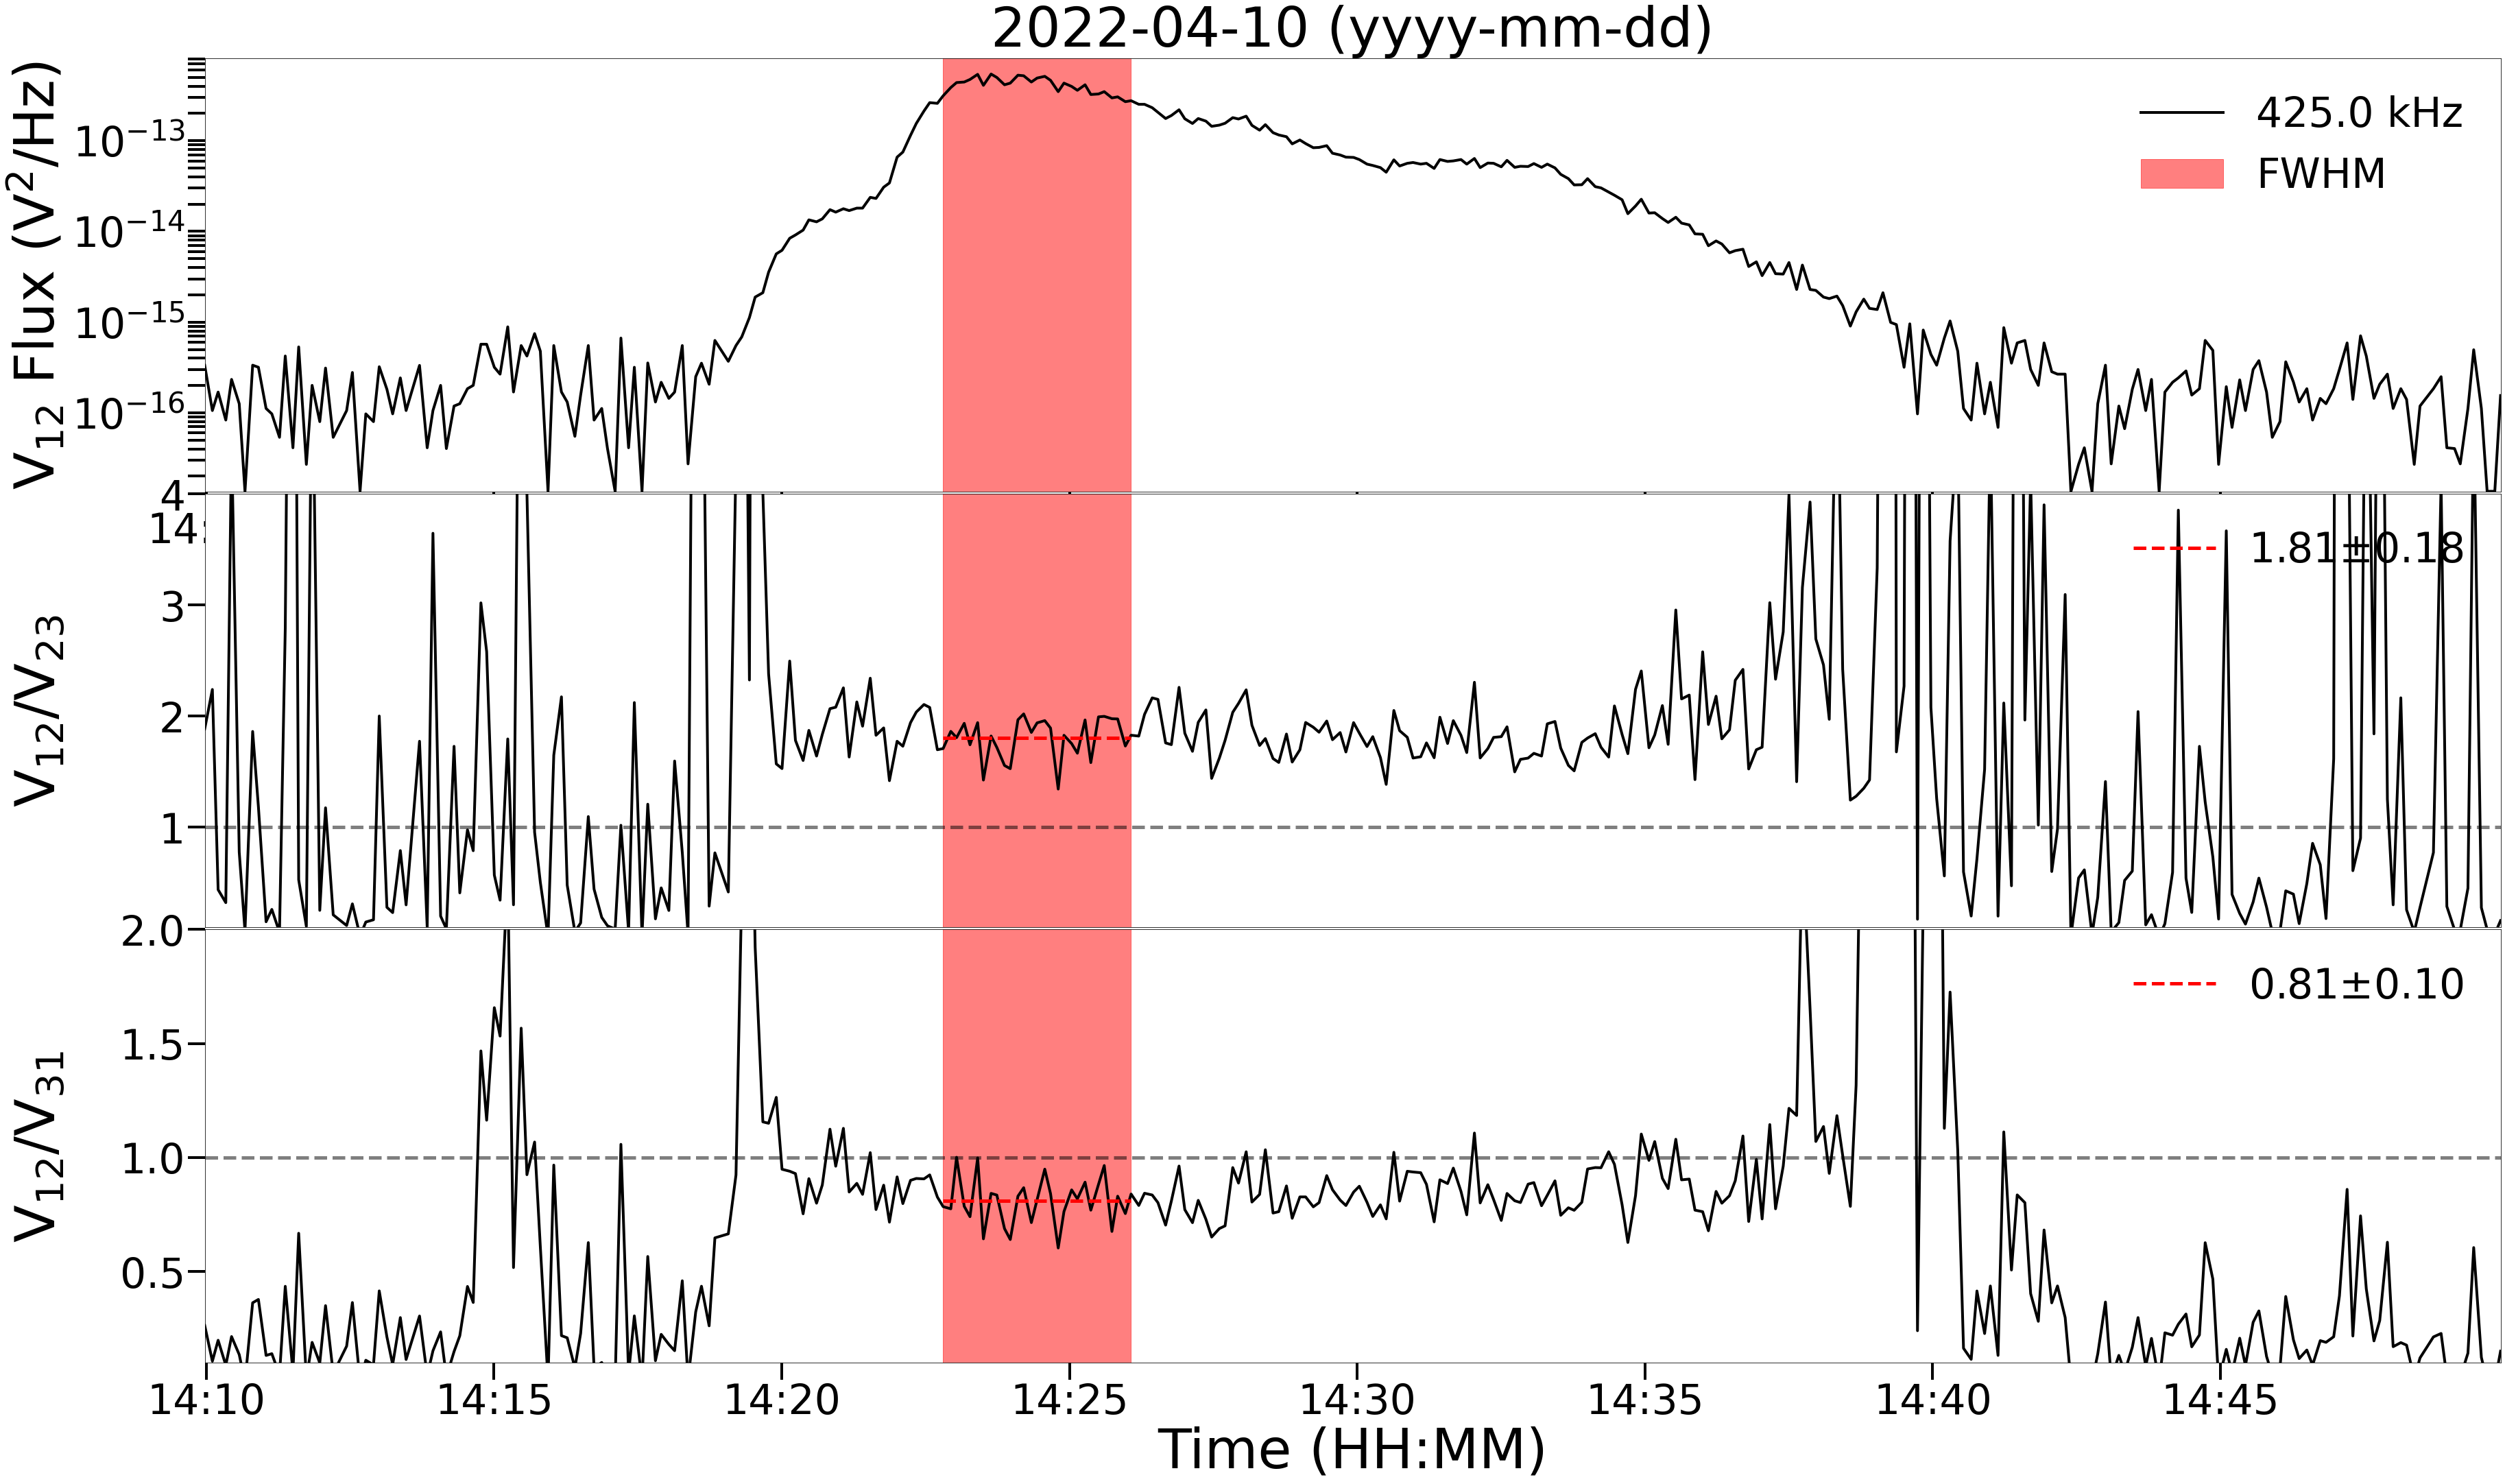

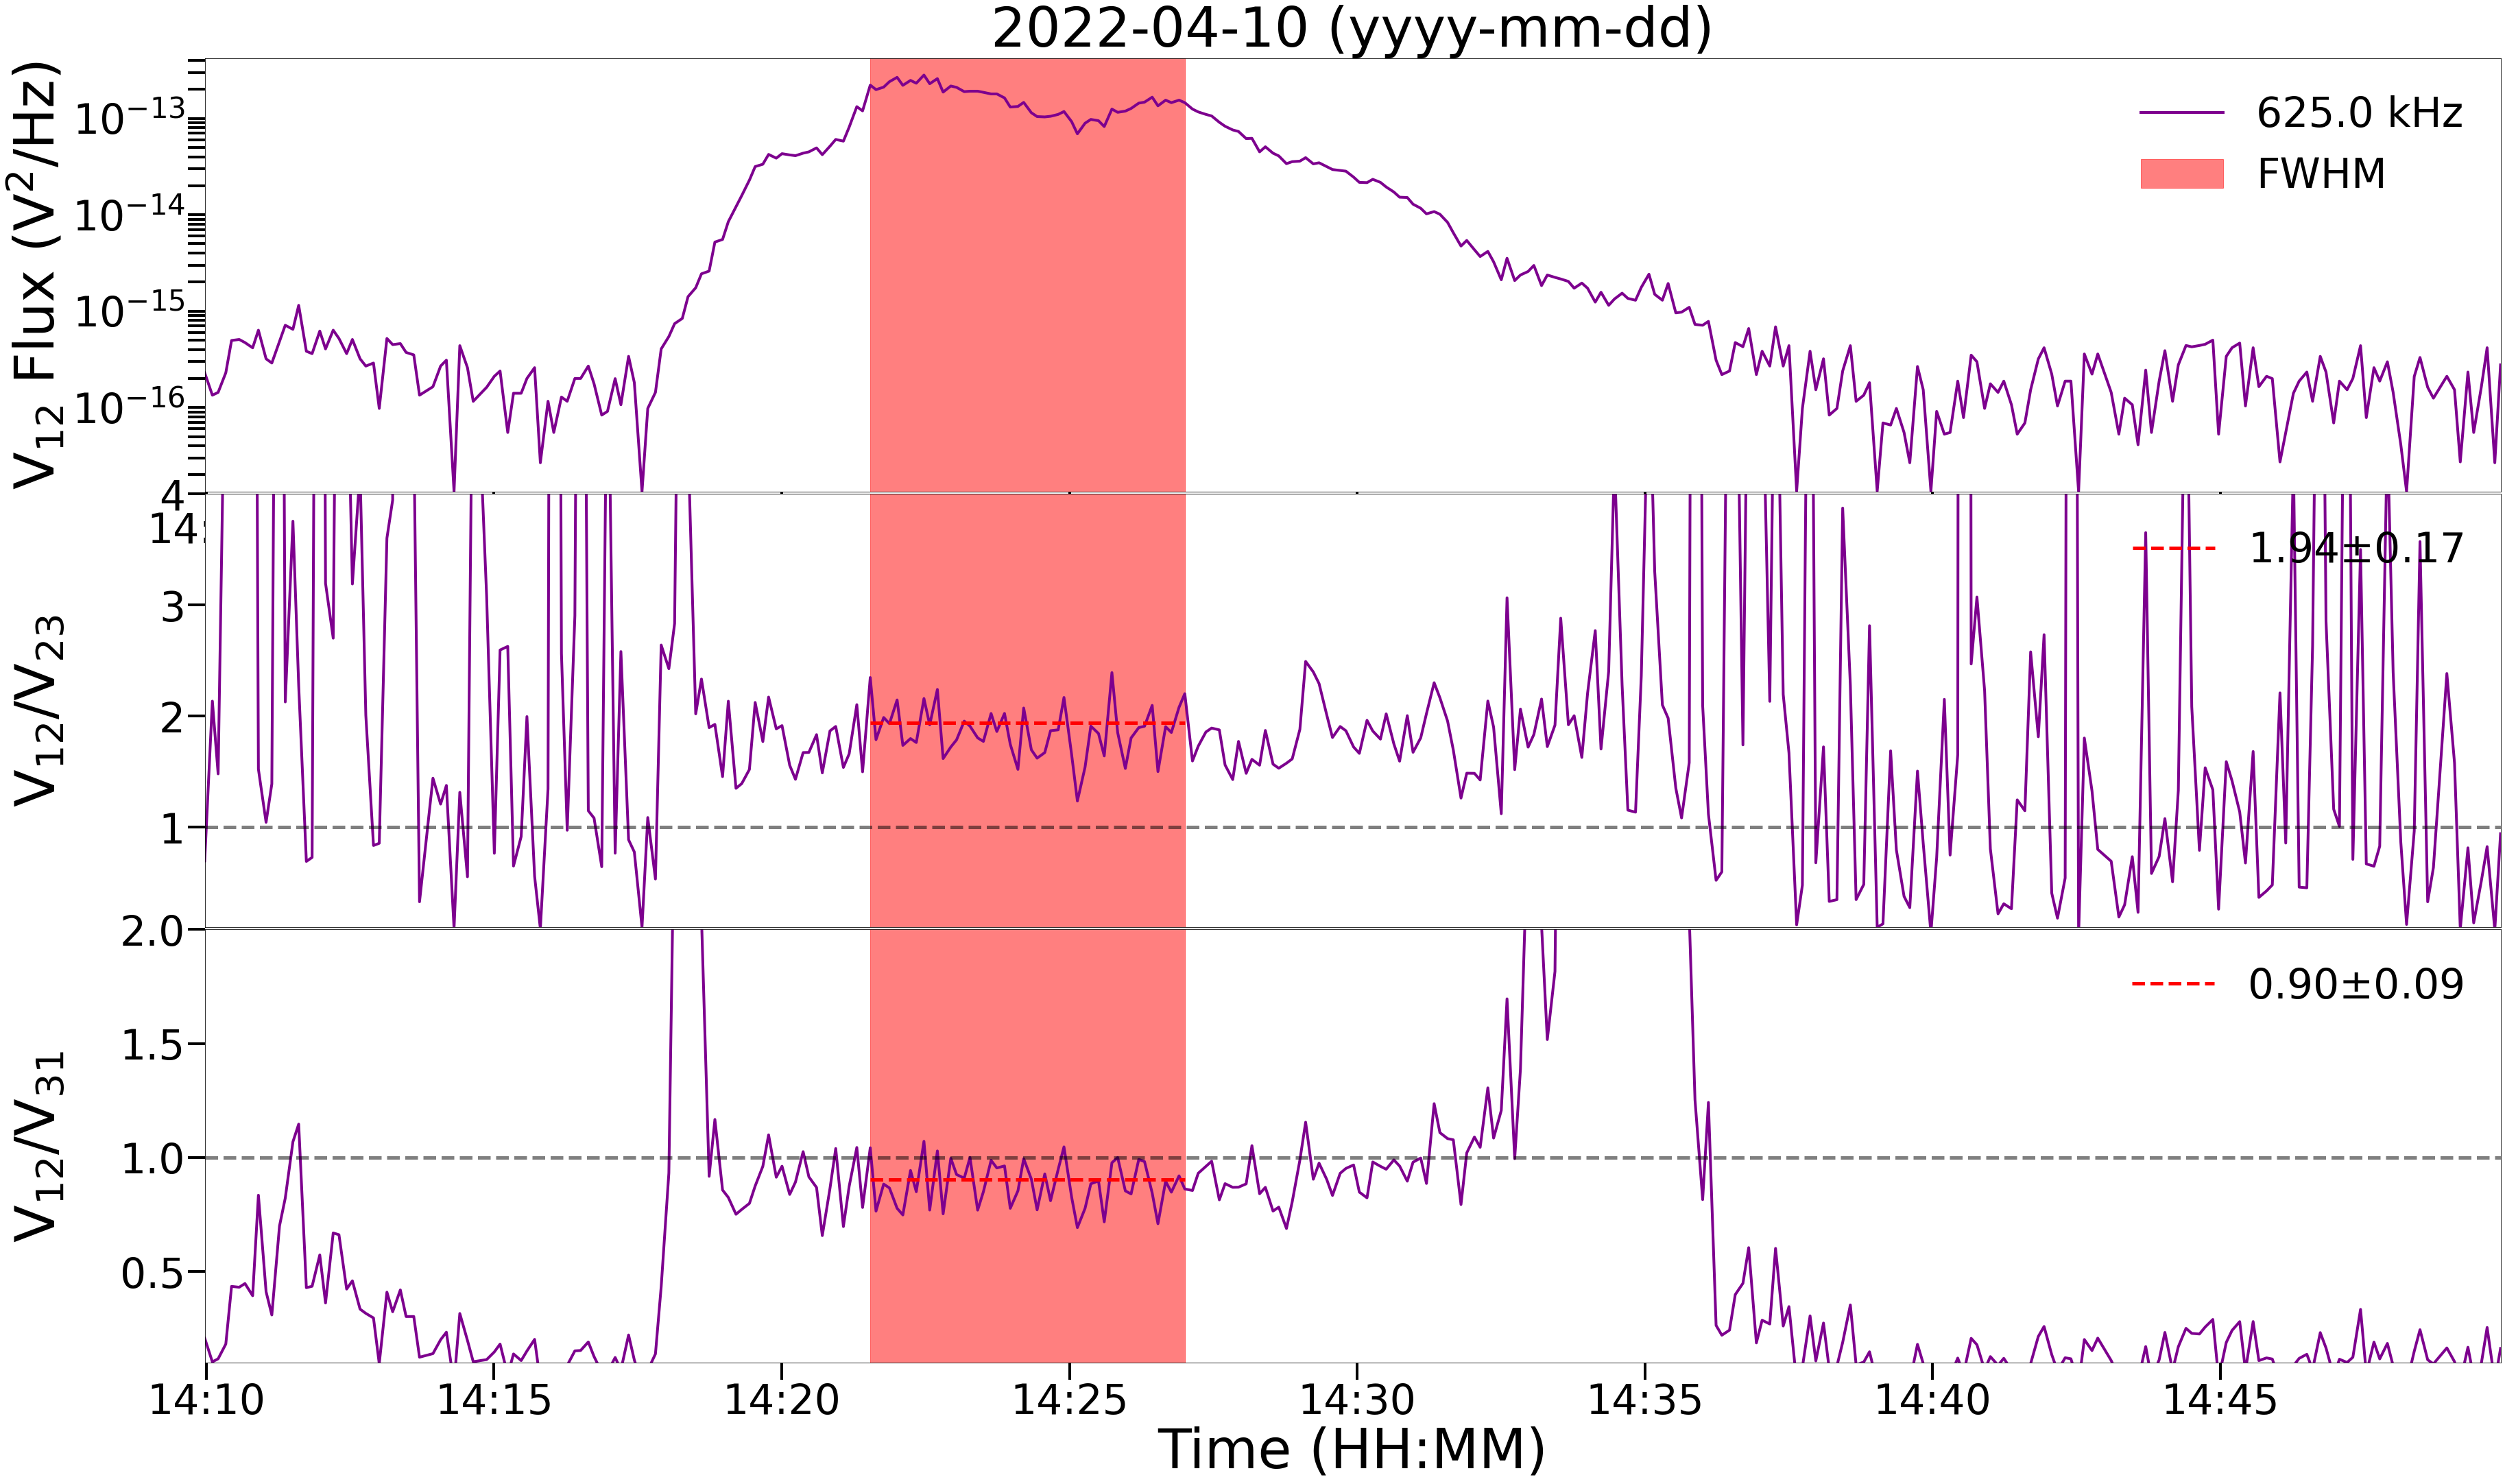

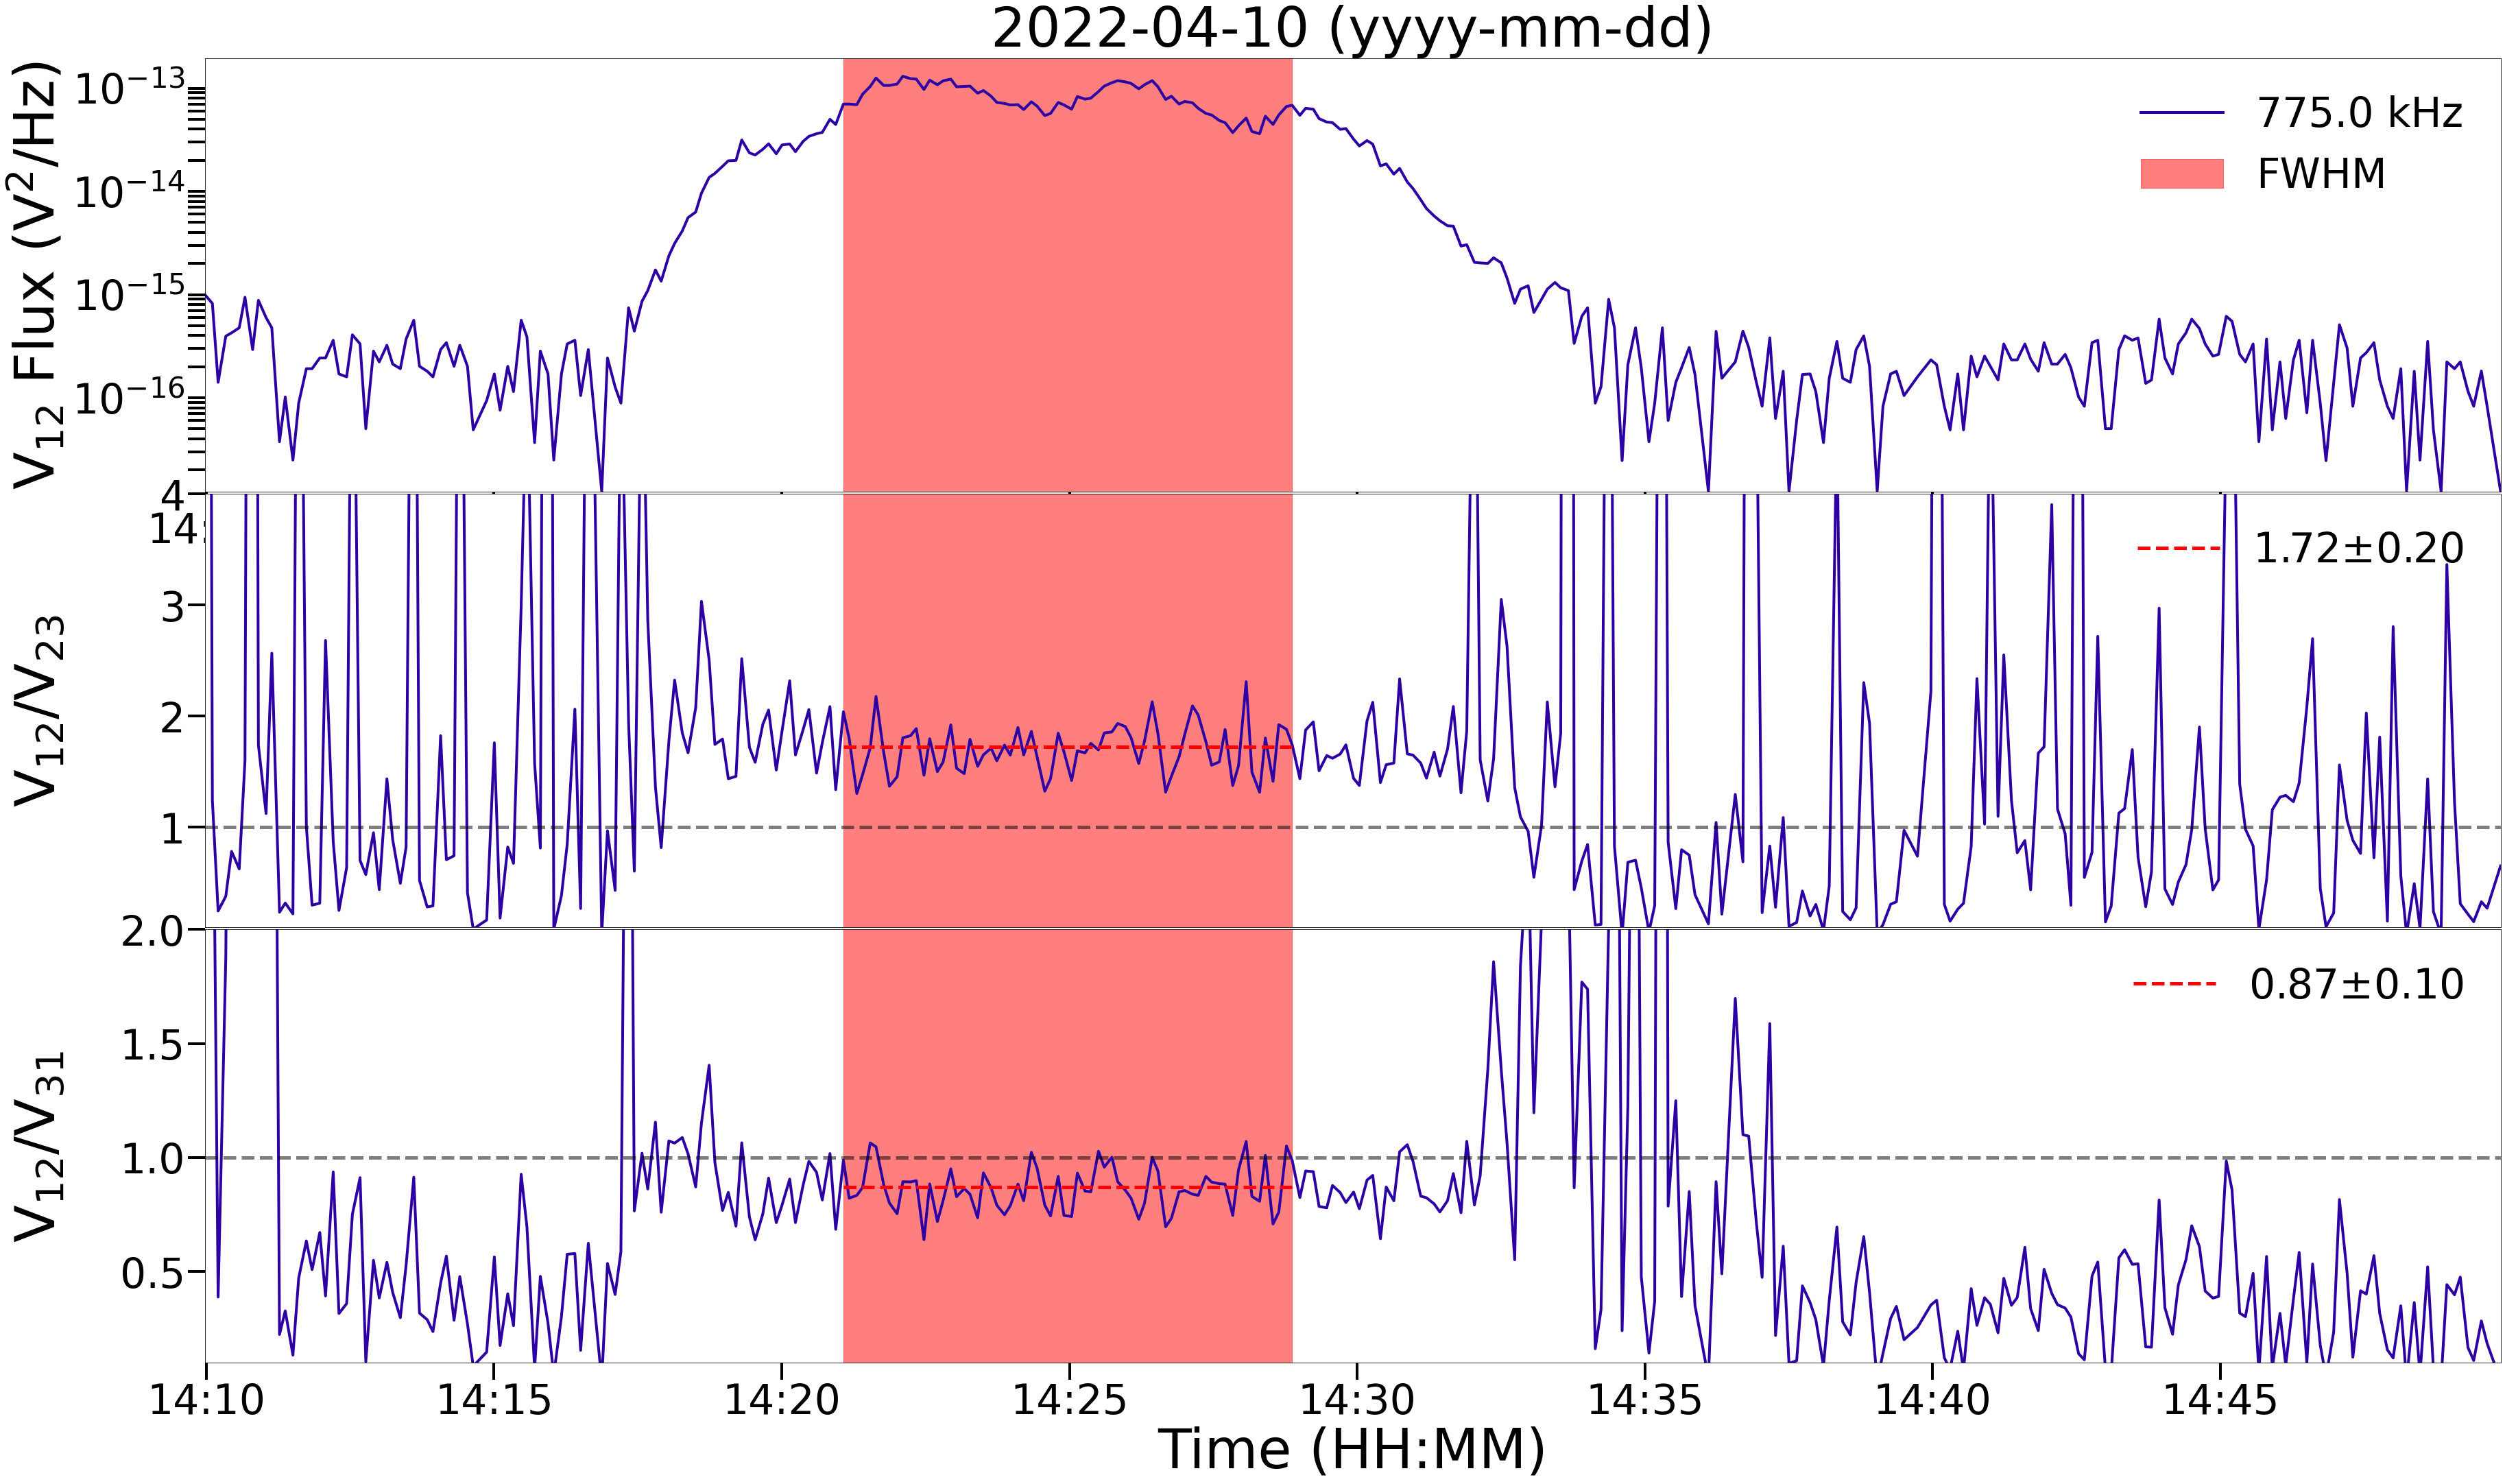

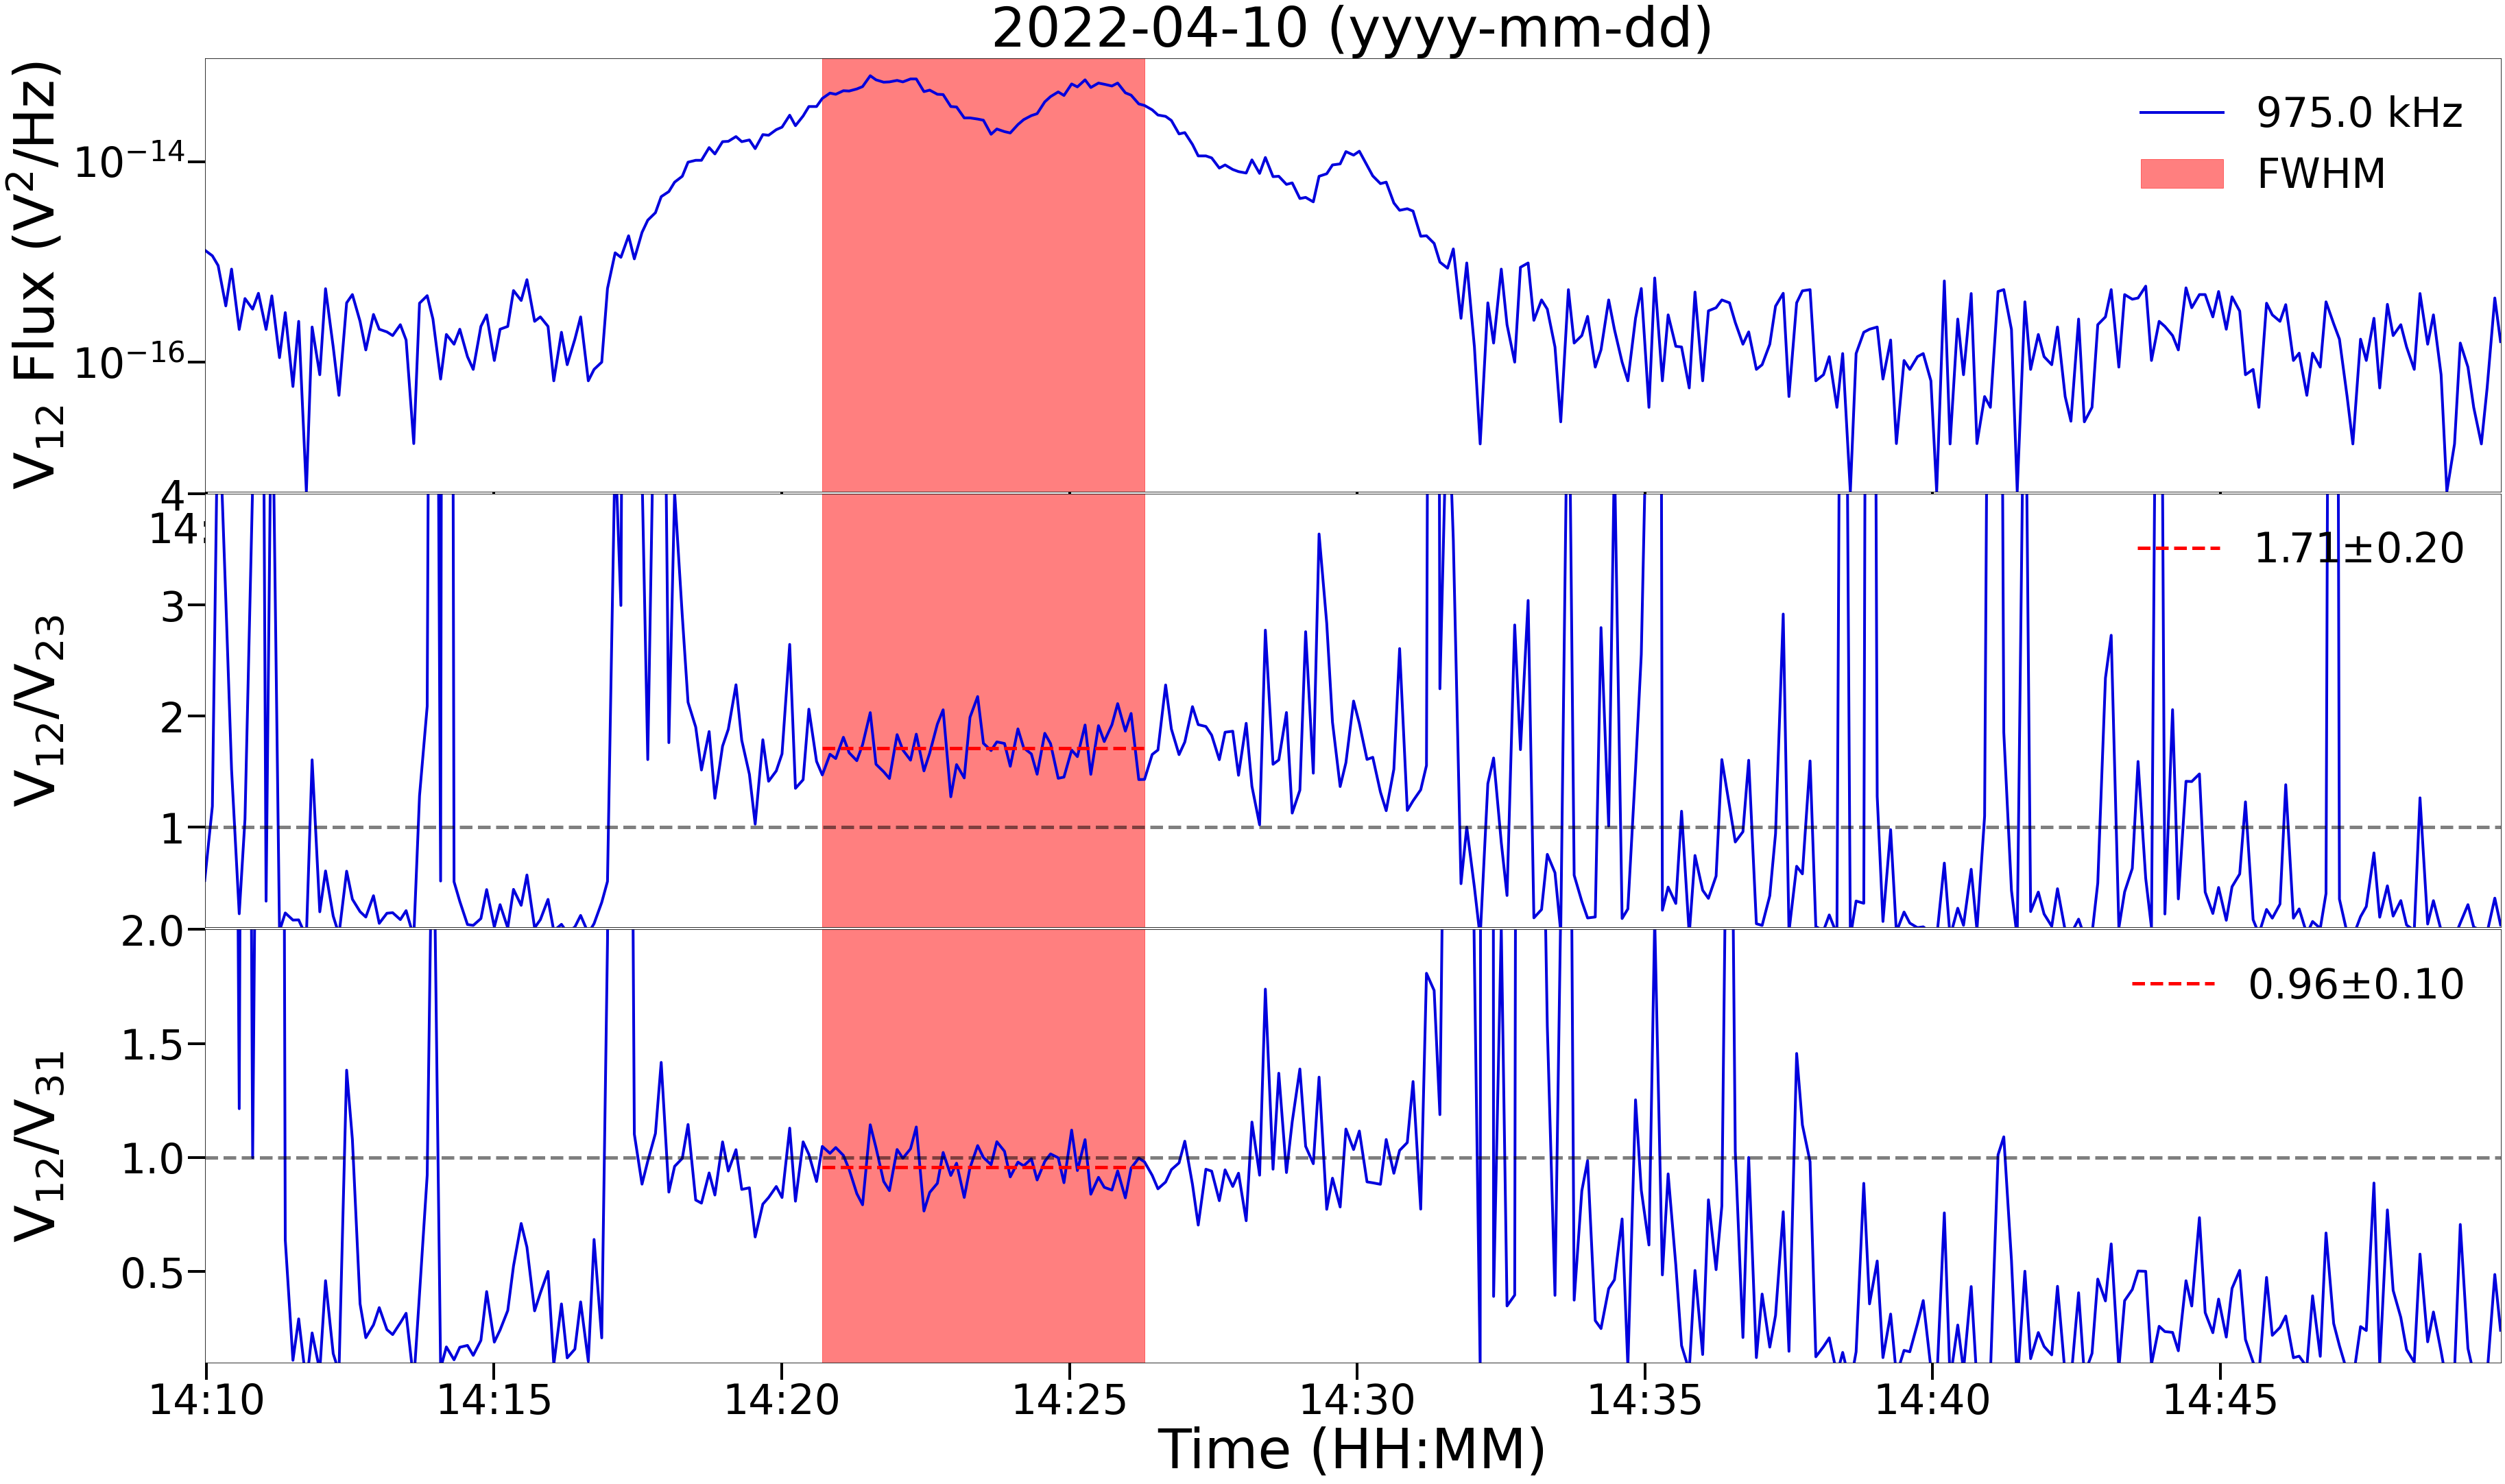

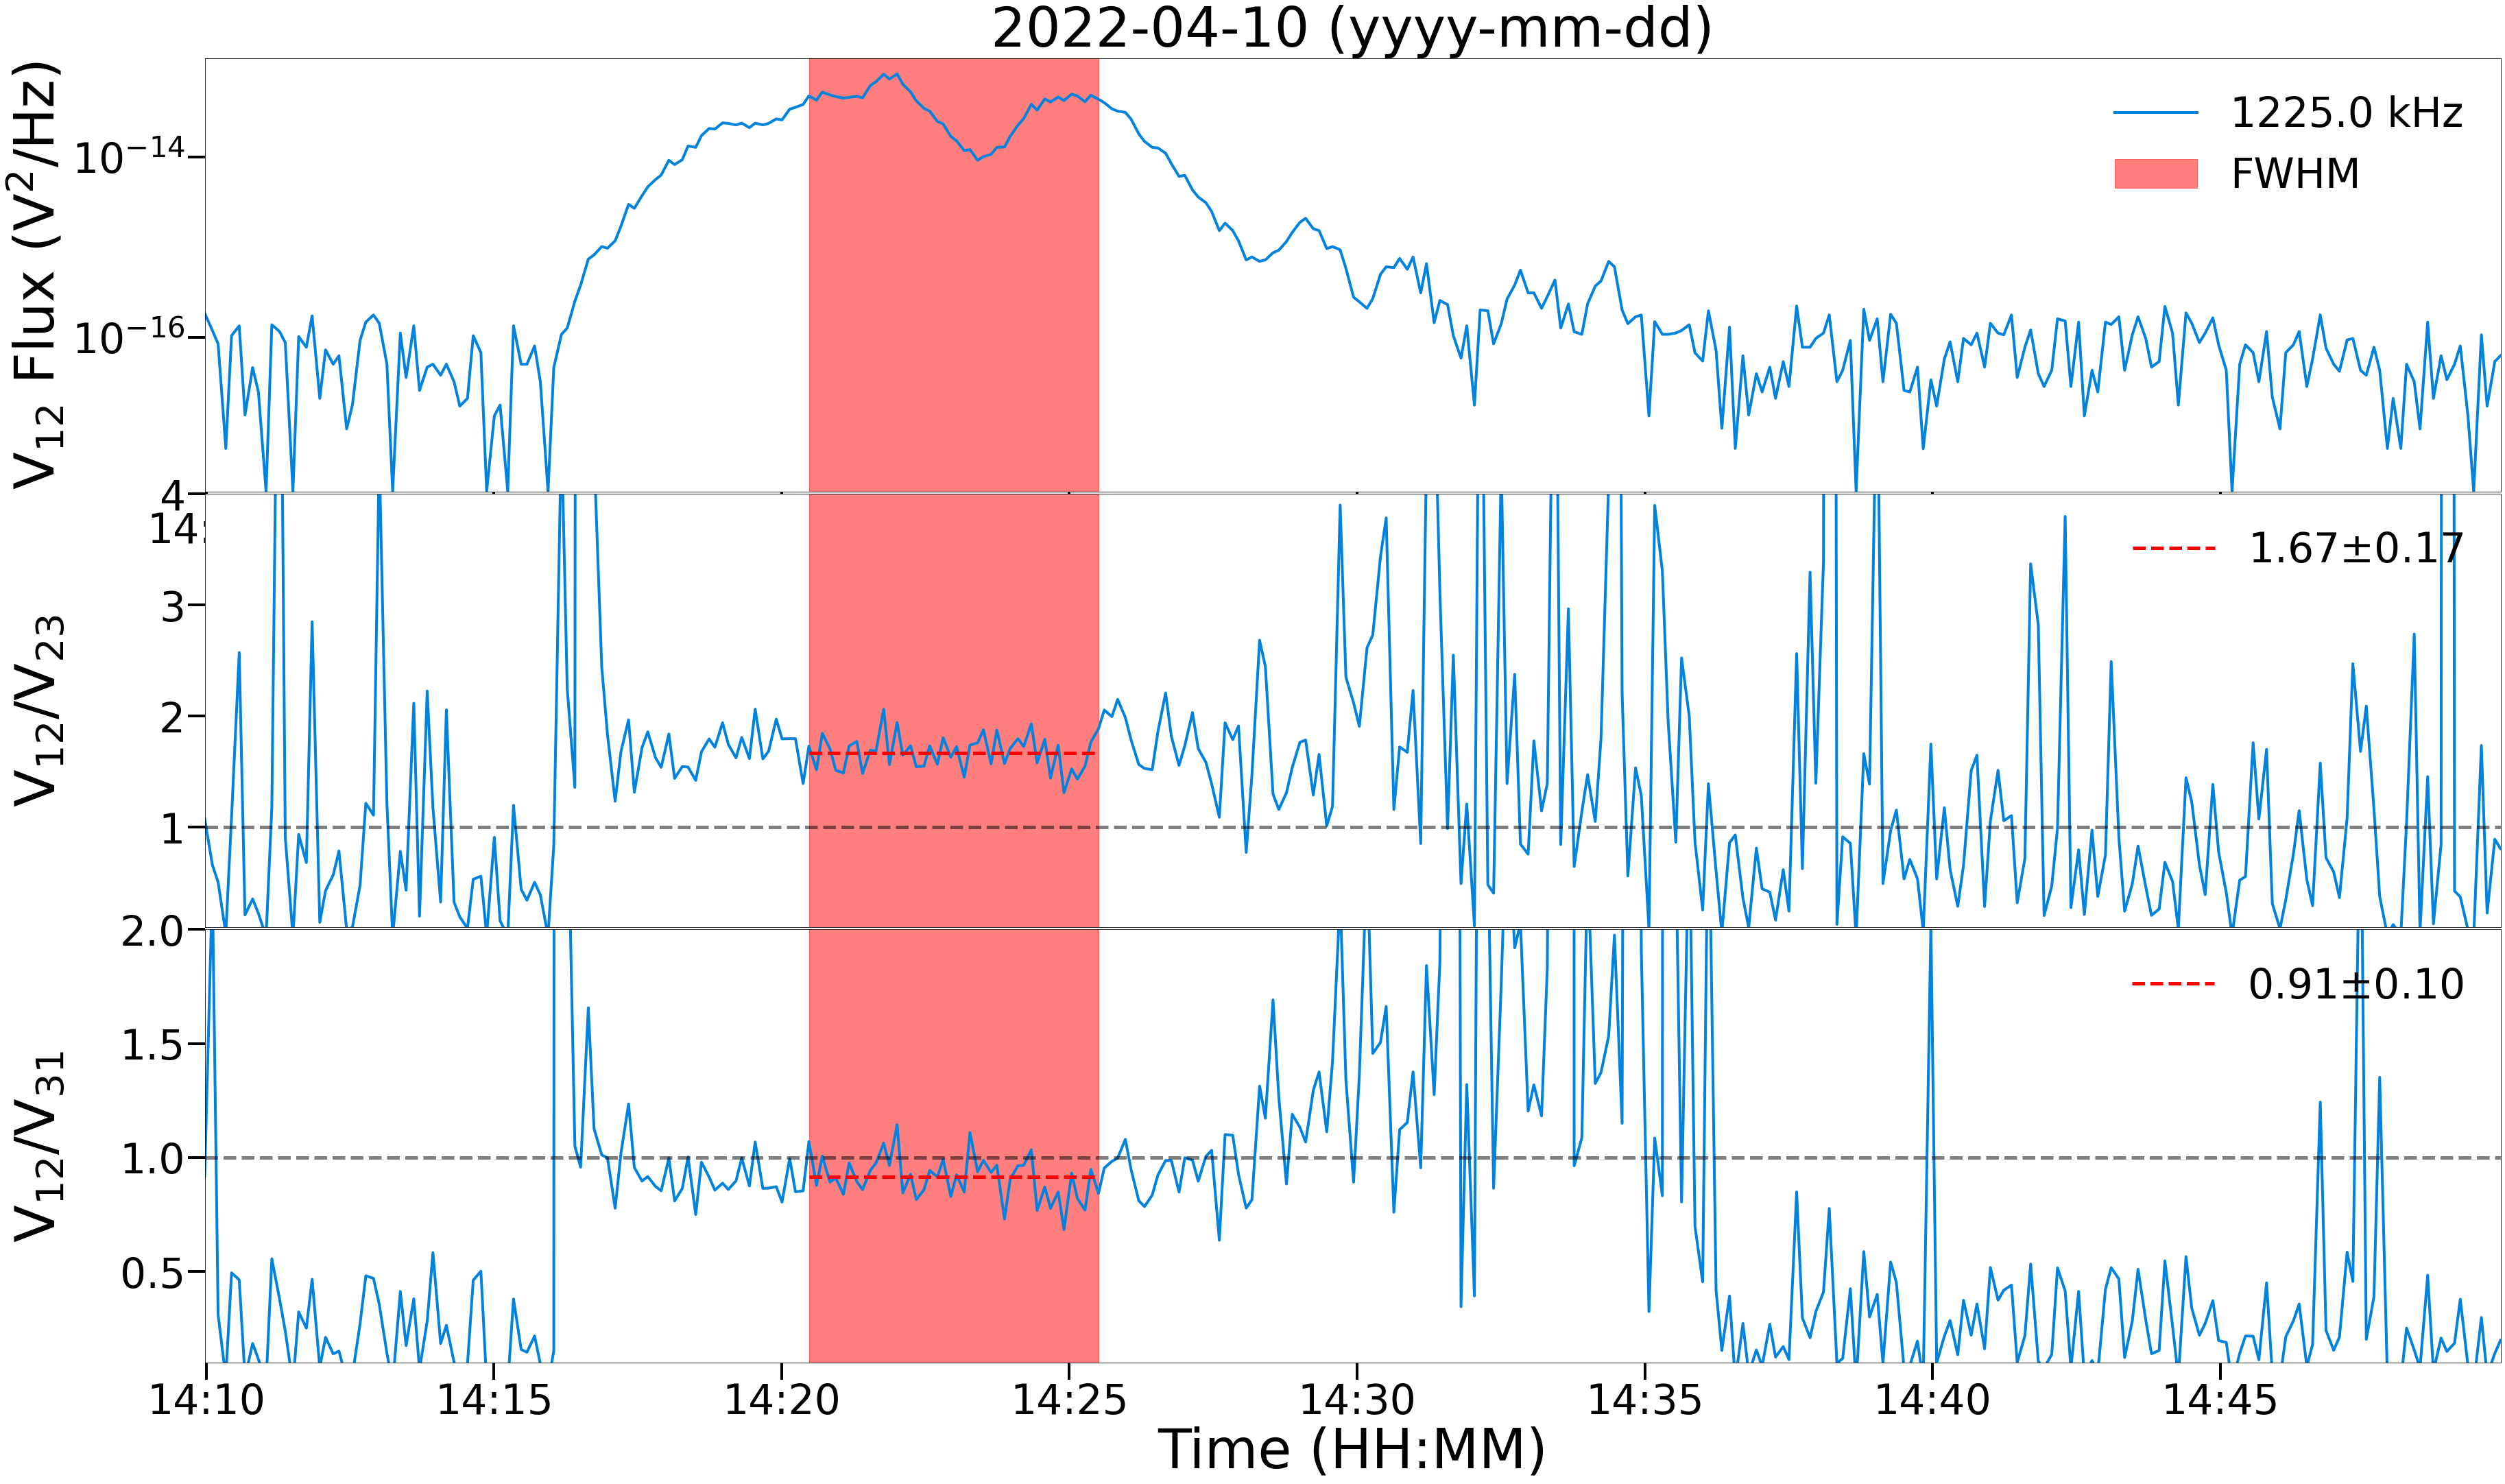

In [15]:
peak_9_10, peak_9_11, peak_10_11 = [], [], []
peak_9_10_err, peak_9_11_err, peak_10_11_err = [], [], []

for i in list(range(0, freq_num)): # For each frequency value
    epoch_axis_9 = to_timestamp(epoch_9[i])
    #print(ten_min_cal_plus(epoch_9[i], AGC_9[i]))
    if int(HH_s)<1:
        AGC_axis_9 = np.abs(AGC_9[i] - ten_min_cal_plus(epoch_9[i], AGC_9[i]))
        # Interpolate and remove median value for filtering
        AGC_axis_10 = np.abs(np.interp(epoch_axis_9, to_timestamp(epoch_10[i]), AGC_10[i]) - ten_min_cal_plus(epoch_10[i], AGC_10[i]))
        AGC_axis_11 = np.abs(np.interp(epoch_axis_9, to_timestamp(epoch_11[i]), AGC_11[i]) - ten_min_cal_plus(epoch_11[i], AGC_11[i]))
    else:
        AGC_axis_9 = np.abs(AGC_9[i] - ten_min_cal(epoch_9[i], AGC_9[i]))
        # Interpolate and remove median value for filtering
        AGC_axis_10 = np.abs(np.interp(epoch_axis_9, to_timestamp(epoch_10[i]), AGC_10[i]) - ten_min_cal(epoch_10[i], AGC_10[i]))
        AGC_axis_11 = np.abs(np.interp(epoch_axis_9, to_timestamp(epoch_11[i]), AGC_11[i]) - ten_min_cal(epoch_11[i], AGC_11[i]))
        
    #---------------------------------------
    # Find the ratios 9/10, 9/11, 10/11
    ratio_9_10 = AGC_axis_9/AGC_axis_10
    ratio_9_11 = AGC_axis_9/AGC_axis_11
    ratio_10_11 = AGC_axis_10/AGC_axis_11
    #---------------------------------------
    # Find ratio around the peak and append it to an array for later plotting:
    # See where the count is greater than half peak, find the ratio for those indexes and average over them
        
    peak_9_10.append(halfpeak_avg(ratio_9_10[start:end], AGC_axis_9[start:end]))
    peak_9_11.append(halfpeak_avg(ratio_9_11[start:end], AGC_axis_9[start:end]))
    peak_10_11.append(halfpeak_avg(ratio_10_11[start:end], AGC_axis_10[start:end]))
    # Errors over the averages
    peak_9_10_err.append(halfpeak_err(ratio_9_10[start:end], AGC_axis_9[start:end]))
    peak_9_11_err.append(halfpeak_err(ratio_9_11[start:end], AGC_axis_9[start:end]))
    peak_10_11_err.append(halfpeak_err(ratio_10_11[start:end], AGC_axis_10[start:end]))
    #---------------------------------------
    # Pick positive values for ratio
    zero_condition = np.where((ratio_9_10[start:end] > 0) & (ratio_9_11[start:end] > 0) & (ratio_10_11[start:end] > 0))
    #---------------------------------------
    # Turn what you want to plot into arrays
    date_to_plot = np.array(to_date(epoch_axis_9)[start:end])
    ratio_9_10_to_plot = np.array(ratio_9_10[start:end])
    ratio_9_11_to_plot = np.array(ratio_9_11[start:end])
    ratio_10_11_to_plot = np.array(ratio_10_11[start:end])
    AGC_to_plot = AGC_axis_9[start:end]
    colors = cm.nipy_spectral(np.linspace(0,0.8, freq_num))
    #print(AGC_axis_9)
    half_max = FWHM(date_to_plot[zero_condition], AGC_to_plot[zero_condition])
    #---------------------------------------
    # Select only a few frequencies
    if np.mod(i, 2) == 0 and i < 9:
        
        fig = plt.figure(figsize=(60,35))
        ax_grid = fig.add_gridspec(1, 1)
        ax_ = ax_grid[0].subgridspec(3, 1, hspace=0.005)
        ax = [fig.add_subplot(ax_[0, 0]), fig.add_subplot(ax_[1, 0]), fig.add_subplot(ax_[2, 0])]
        
        ax[0].plot(date_to_plot[zero_condition], AGC_to_plot[zero_condition], label=str(freq_list[i]) + ' kHz', c=colors[i], linewidth=4)
        ax[1].plot(date_to_plot[zero_condition], ratio_9_10_to_plot[zero_condition], c=colors[i], linewidth=4)
        ax[2].plot(date_to_plot[zero_condition], ratio_9_11_to_plot[zero_condition], c=colors[i], linewidth=4)
    
        date_for_lim = np.array(to_date(epoch_axis_9)[start:end])
        x_dates = date_for_lim
        
        avg_9_10 = str('%.2f' % halfpeak_avg(ratio_9_10[start:end], AGC_axis_9[start:end]))
        err_9_10 = str('%.2f' % halfpeak_err(ratio_9_10[start:end], AGC_axis_9[start:end]))
        avg_9_11 = str('%.2f' % halfpeak_avg(ratio_9_11[start:end], AGC_axis_9[start:end]))
        err_9_11 = str('%.2f' % halfpeak_err(ratio_9_11[start:end], AGC_axis_9[start:end]))
        lbl_9_10 = avg_9_10 + '$\pm$' + err_9_10
        lbl_9_11 = avg_9_11 + '$\pm$' + err_9_11
        for a in ax:
            a.xaxis.set_major_formatter(myFmt)
            a.tick_params(axis='both', which='both', labelsize=60, length=25, width=4)
            a.set_xlim(x_dates[0], x_dates[-1])
            #a.set_yscale("log")
        
        ax[0].axvspan(np.min([half_max[0]]), np.max([half_max[1]]), 0, 15, color='r', alpha=0.5, label='FWHM')
        ax[0].legend(loc='upper right', fontsize = 60, frameon=False) #bbox_to_anchor=(1, 1)
        ax[0].set_ylabel('V$_{12}$ Flux (V$^2$/Hz)', fontsize=80)
        ax[0].yaxis.set_label_coords(-0.06, .5)
        ax[0].set_title(date + ' (yyyy-mm-dd)', fontsize=80)
        ax[0].set_ylim(np.min(AGC_to_plot[zero_condition]), 1.5*np.max(AGC_to_plot[zero_condition]))
        ax[0].set_yscale("log")
        ax[1].axvspan(np.min([half_max[0]]), np.max([half_max[1]]), 0, 15, color='r', alpha=0.5)
        ax[1].set_ylabel('V$_{12}$/V$_{23}$', fontsize=80)
        ax[1].yaxis.set_label_coords(-0.06, .5)
        ax[1].set_ylim(0.1, 4)
        ax[1].hlines(1, x_dates[0], x_dates[-1], 'k', linestyle='--',linewidth=5, alpha=0.5)
        ax[1].hlines(halfpeak_avg(ratio_9_10[start:end], AGC_axis_9[start:end]), np.min([half_max[0]]), np.max([half_max[1]]), 'r', linestyle='--',linewidth=5, label=lbl_9_10)
        ax[1].set_xticks([])
        ax[1].legend(loc='upper right', fontsize = 60, frameon=False)
        ax[2].axvspan(np.min([half_max[0]]), np.max([half_max[1]]), 0, 15, color='r', alpha=0.5)
        ax[2].set_ylim(0.1, 2)
        ax[2].set_xlabel('Time (HH:MM)', fontsize=80)
        ax[2].set_ylabel('V$_{12}$/V$_{31}$', fontsize=80)
        ax[2].yaxis.set_label_coords(-0.06, .5)
        ax[2].hlines(1, x_dates[0], x_dates[-1], 'k', linestyle='--',linewidth=5, alpha=0.5)
        ax[2].hlines(halfpeak_avg(ratio_9_11[start:end], AGC_axis_9[start:end]), np.min([half_max[0]]), np.max([half_max[1]]), 'r', linestyle='--',linewidth=5, label=lbl_9_11)
        ax[2].legend(loc='upper right', fontsize = 60, frameon=False)
        
        if save_results == True:
            plt.savefig("RPW_Flux_and_Ratio\RPW_" + date + '_' + HH_s + '_' + HH_e + '_' + str(freq_list[i]) + 'kHz' + ".png", bbox_inches='tight')

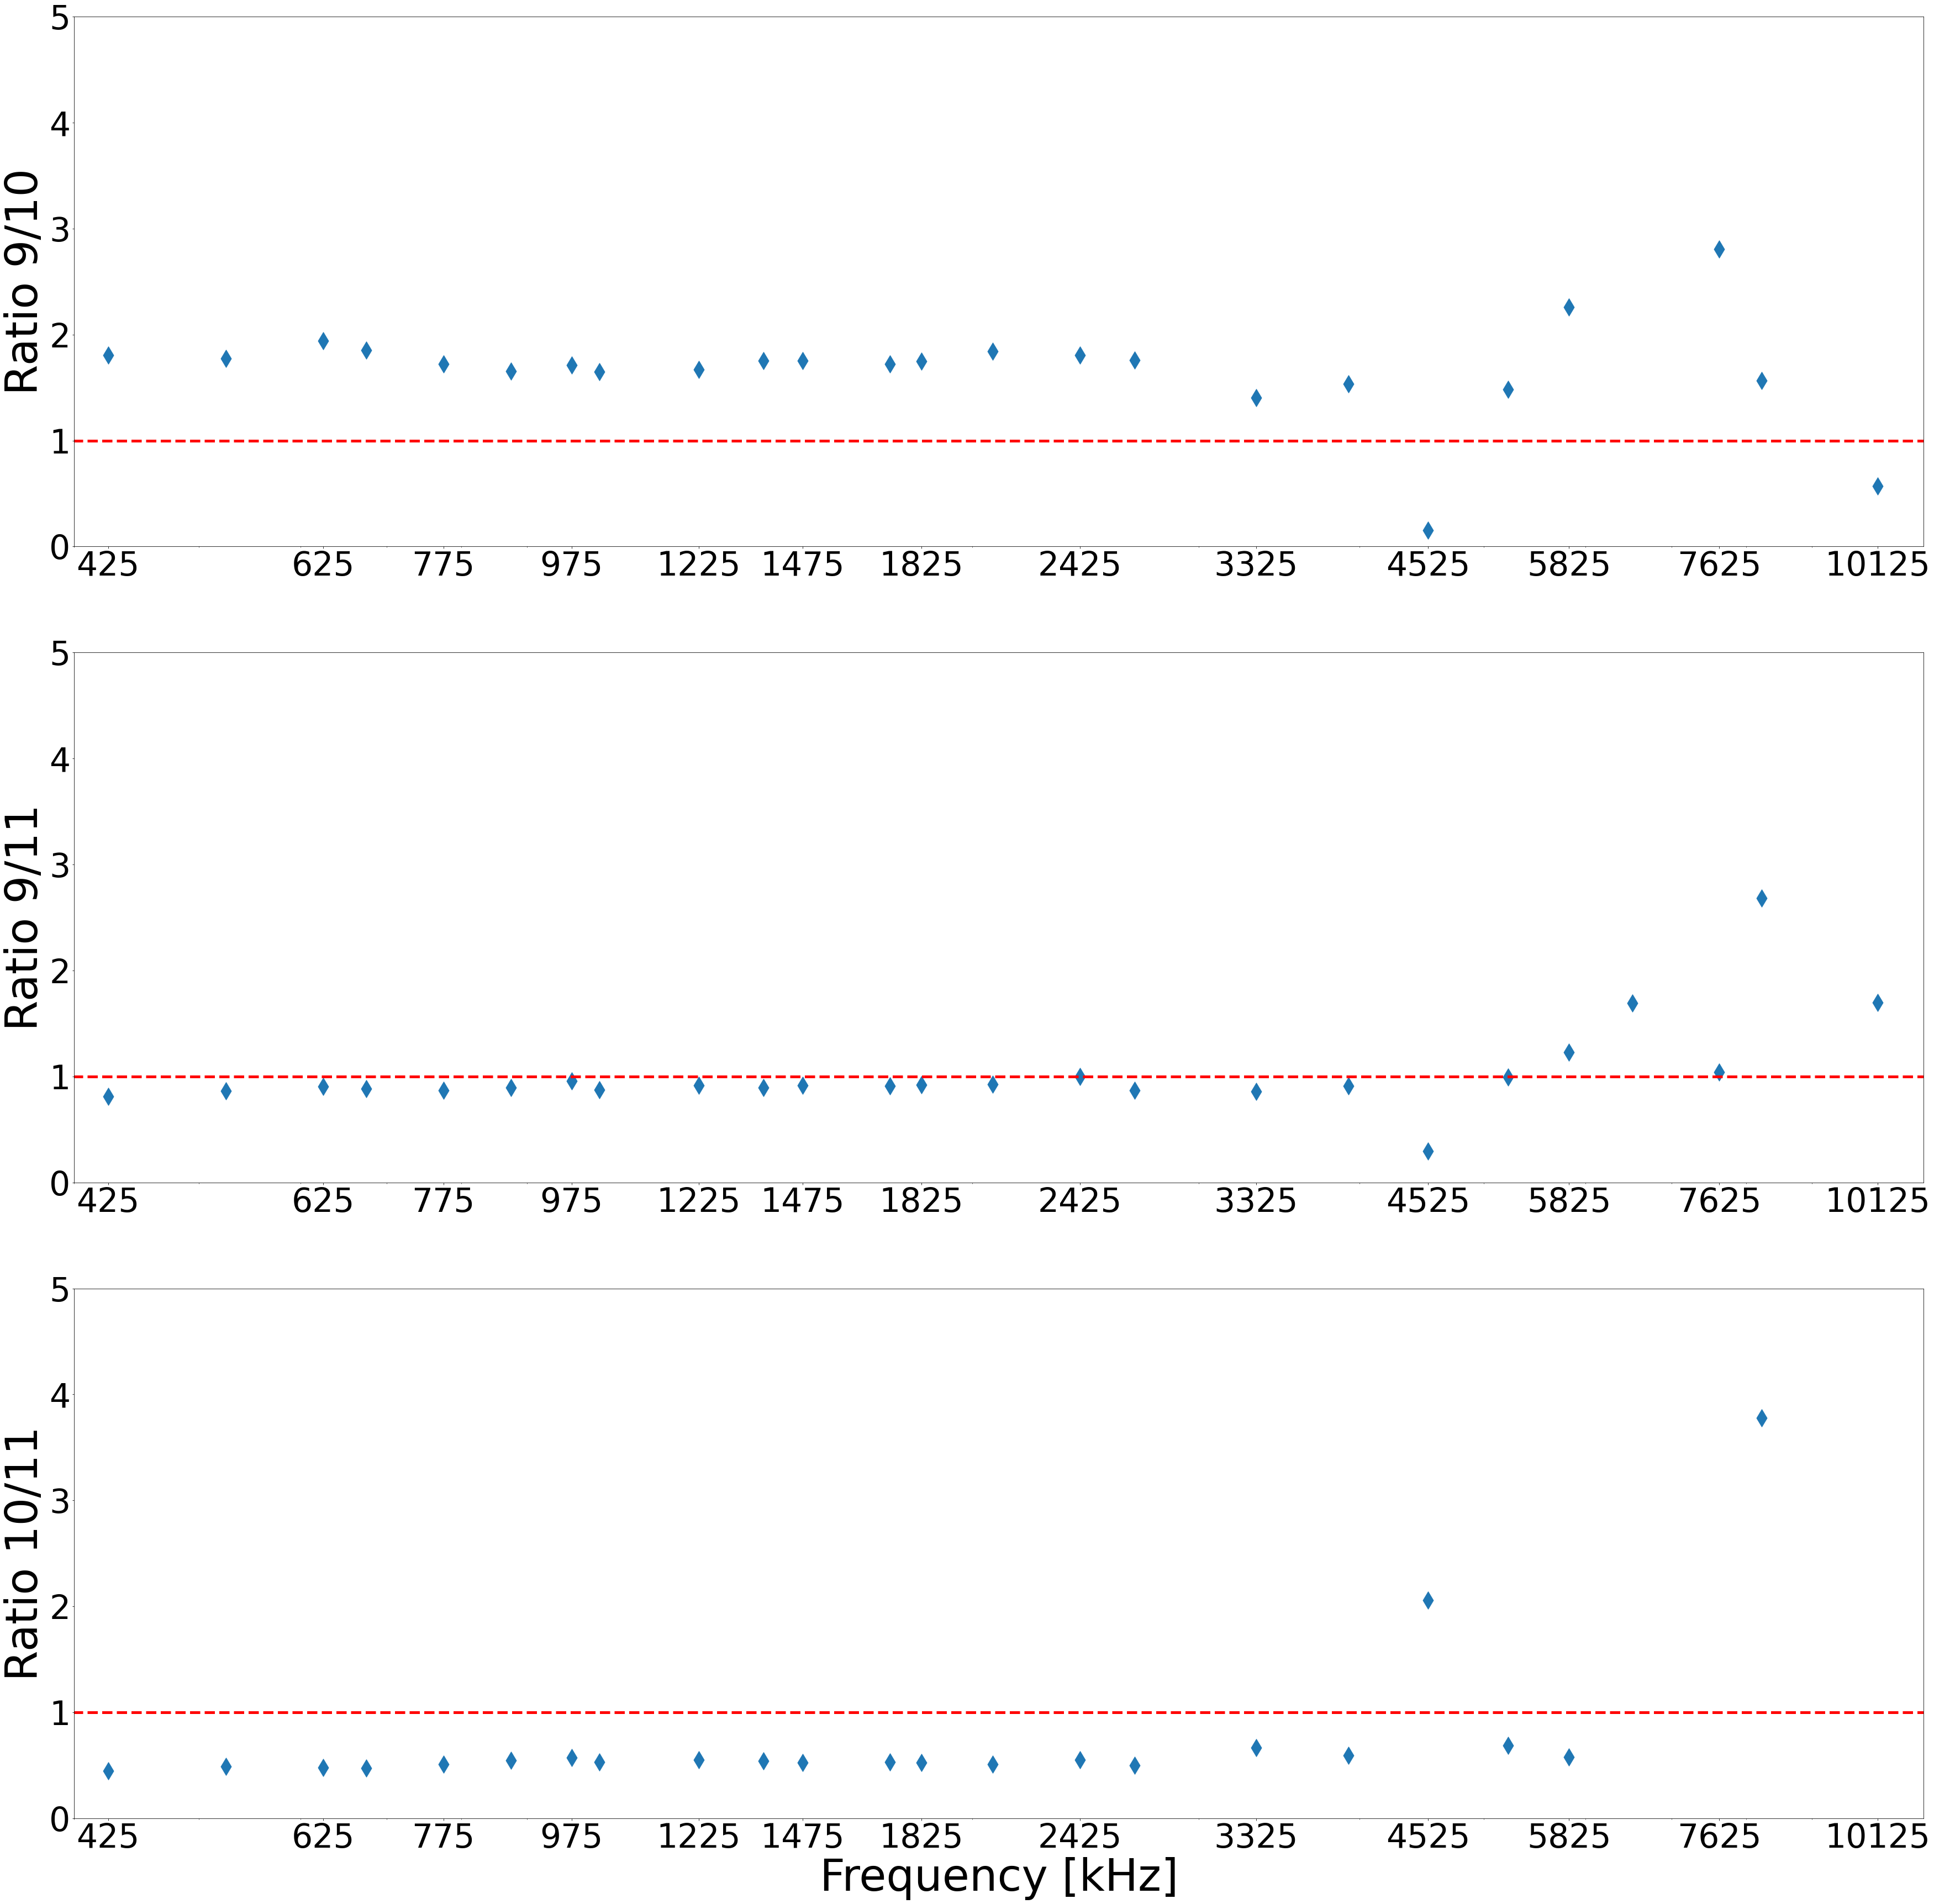

In [16]:
# Plot the ratio at the peak as a function of frequency
fig = plt.figure(figsize=(60,60))
ax_grid = fig.add_gridspec(1, 1)
ax_ = ax_grid[0].subgridspec(3, 1)

ax = [fig.add_subplot(ax_[0, 0]), fig.add_subplot(ax_[1, 0]), fig.add_subplot(ax_[2, 0])]

ax[0].scatter(freq_list, peak_9_10, s=500, marker='d')
ax[1].scatter(freq_list, peak_9_11, s=500, marker='d')
ax[2].scatter(freq_list, peak_10_11, s=500, marker='d')

for a in ax:
    a.tick_params(axis='both', which='both', labelsize=60)
    a.set_xscale("log")
    a.set_ylim(0,5)
    a.set_xlim(400,11000)
    a.set_xticks(freq_list[::2])
    a.xaxis.set_major_formatter(ScalarFormatter())
    a.hlines(1, 300, 20000, 'r', linestyle='--', linewidth=5)

ax[2].set_xlabel('Frequency [kHz]', fontsize=80)
ax[0].set_ylabel('Ratio 9/10', fontsize=80)
ax[1].set_ylabel('Ratio 9/11', fontsize=80)
ax[2].set_ylabel('Ratio 10/11', fontsize=80)

if save_results == True:
    plt.savefig("RPW_Ratio_vs_Freq\\RPW_RvsF_" + date + '_' + HH_s + '_' + HH_e + ".png", bbox_inches='tight')

    np.savetxt("RPW_Ratio_Arrays\\9_10\\peak_9_10_" + date + '_' + HH_s + '_' + HH_e + ".txt", np.array(peak_9_10), fmt='%1.3f')
    np.savetxt("RPW_Ratio_Arrays\\9_11\\peak_9_11_" + date + '_' + HH_s + '_' + HH_e + ".txt", np.array(peak_9_11), fmt='%1.3f')
    np.savetxt("RPW_Ratio_Arrays\\10_11\\peak_10_11_" + date + '_' + HH_s + '_' + HH_e + ".txt", np.array(peak_10_11), fmt='%1.3f')

    np.savetxt("RPW_Ratio_Errors\\9_10\\peak_9_10_err_" + date + '_' + HH_s + '_' + HH_e + ".txt", np.array(peak_9_10_err), fmt='%1.3f')
    np.savetxt("RPW_Ratio_Errors\\9_11\\peak_9_11_err_" + date + '_' + HH_s + '_' + HH_e + ".txt", np.array(peak_9_11_err), fmt='%1.3f')
    np.savetxt("RPW_Ratio_Errors\\10_11\\peak_10_11_err_" + date + '_' + HH_s + '_' + HH_e + ".txt", np.array(peak_10_11_err), fmt='%1.3f')  

In [17]:
# Computes time resolution
def time_res(a):
    diff = np.diff(a)
    diff_in_sec = list(map(lambda x: x.seconds, diff))
    return diff_in_sec

resolut = statistics.mode(time_res(epoch_9[0]))
print('The time resolution is: ' + str(resolut) + 's')

The time resolution is: 7s


In [18]:
if save_results == True:
    # Adds date to the list of dates analysed
    with open("RPW_dates_analysed.txt", "a") as myfile:
        myfile.write(date + ' ' + start_event + '-' + end_event + ', ')